# Face Recognizer performance evaluation

Deepface is a hybrid face recognition package. It currently wraps many state-of-the-art face recognition models: VGG-Face , Google FaceNet, OpenFace, Facebook DeepFace, DeepID, ArcFace, Dlib and SFace. The default configuration uses VGG-Face model.

In [1]:
from sklearn.datasets import fetch_lfw_pairs
import matplotlib.pyplot as plt
import time

from deepface import DeepFace
from tqdm.notebook import tqdm

In [2]:
fetch_lfw_pairs = fetch_lfw_pairs(subset='test', color=True, resize=1)

In [3]:
# LFW pairs store image pairs and its label as same person or different persons.
pairs = fetch_lfw_pairs.pairs
labels = fetch_lfw_pairs.target
target_names = fetch_lfw_pairs.target_names

In [4]:
# Explore the example of data
print('Number of pairs: {}'.format(len(pairs)))
print('Number of labels: {}'.format(len(labels)))
print('Number of target names: {}'.format(len(target_names)))
print('Shape of pairs: {}'.format(pairs.shape))
print('Shape of labels: {}'.format(labels.shape))
print('Shape of target names: {}'.format(target_names.shape))

Number of pairs: 1000
Number of labels: 1000
Number of target names: 2
Shape of pairs: (1000, 2, 125, 94, 3)
Shape of labels: (1000,)
Shape of target names: (2,)


Same persons


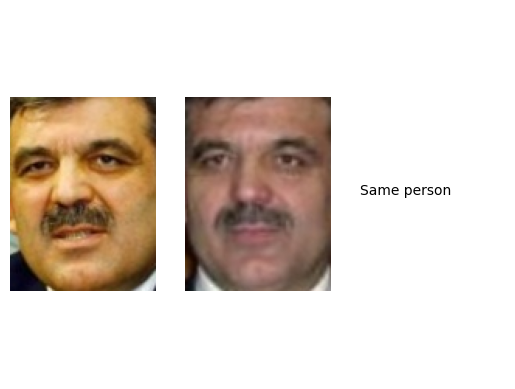

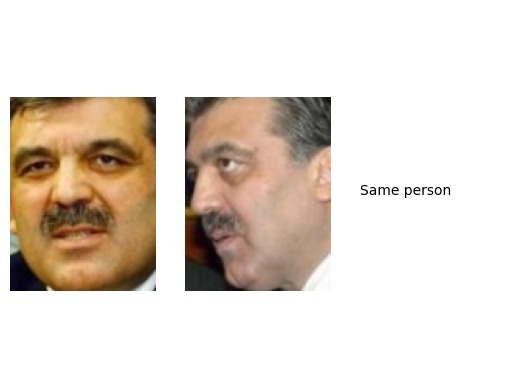

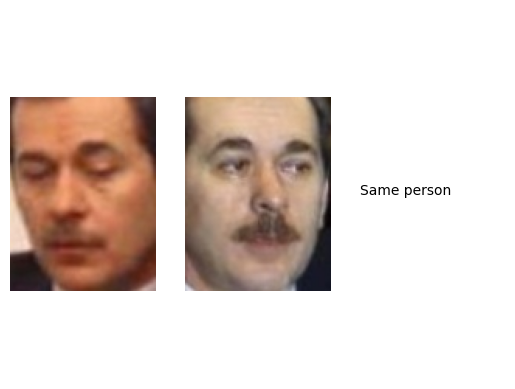

Different persons


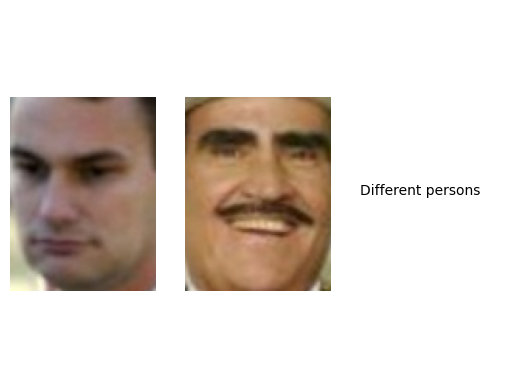

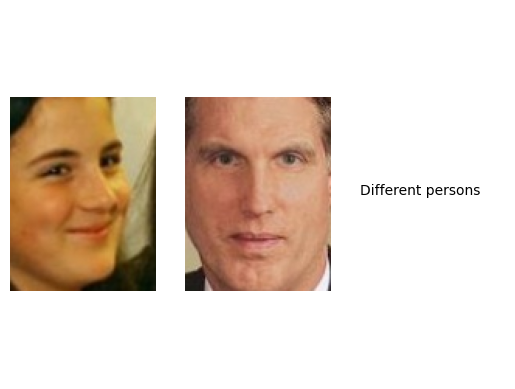

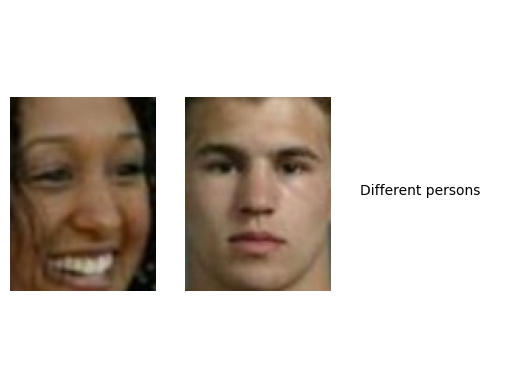

In [5]:
# Show the example of data
# Positive cases
print('Same persons')
for i in range(0, 3):
    pair = pairs[i]
    img1 = pair[0]
    img2 = pair[1]

    fig = plt.figure()

    ax1 = fig.add_subplot(1, 3, 1)
    ax1.axis('off')
    plt.imshow(img1)

    ax2 = fig.add_subplot(1, 3, 2)
    ax2.axis('off')
    plt.imshow(img2)

    ax3 = fig.add_subplot(1, 3, 3)
    ax3.axis('off')
    plt.text(0, 0.50, target_names[labels[i]])

    plt.show()

# Negative cases
print('Different persons')
for i in range(len(pairs) - 1, len(pairs) - 4, -1):
    pair = pairs[i]
    img1 = pair[0]
    img2 = pair[1]

    fig = plt.figure()

    ax1 = fig.add_subplot(1, 3, 1)
    ax1.axis('off')
    plt.imshow(img1)

    ax2 = fig.add_subplot(1, 3, 2)
    ax2.axis('off')
    plt.imshow(img2)

    ax3 = fig.add_subplot(1, 3, 3)
    ax3.axis('off')
    plt.text(0, 0.50, target_names[labels[i]])

    plt.show()

In [45]:
# Predict with each model to see performance with LFW dataset
models = [
    "VGG-Face",
    "Facenet",
    "Facenet512",
    "OpenFace",
    "DeepFace",
    "DeepID",
    "ArcFace",
    "SFace",
]

# Detector model -> use Yunet
backend_detector = "yunet"
# use metric as Euclidean L2 form from author's clain
distance_metric = "cosine"
# prevent exception when the face is not detected
enforce_detection = False
align = True
# Normalization technique -> base = no normalization
normalization = "base"

model_results = {}
for model in tqdm(models):
    predictions = []
    time_usages = []
    actuals = []
    for idx in tqdm(range(pairs.shape[0])):
        pair = pairs[idx]
        img1 = pair[0]
        img2 = pair[1]

        
        # Convert bgr image to rgb for deepface
        img1 = img1[:, :, ::-1]
        img2 = img2[:, :, ::-1]

        # DeepFace Verification
        tic = time.time()
        obj_result = DeepFace.verify(
            img1_path=img1,
            img2_path=img2,
            model_name=model,
            detector_backend=backend_detector,
            distance_metric=distance_metric,
            enforce_detection=enforce_detection,
            align=align,
            normalization=normalization,
        )
        toc = time.time()
        time_usage = toc - tic
        prediction = obj_result["verified"]
        actual = True if labels[idx] == 1 else False
        predictions.append(prediction)
        actuals.append(actual)
        time_usages.append(time_usage)
    model_results[model] = {
        "predictions": predictions,
        "actuals": actuals,
        "time_usages": time_usages,
    }

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [47]:
# Evaluate the performance of each model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

evaluation_results = {}

for model in tqdm(models):
    accuracy = 100 * accuracy_score(model_results[model]["actuals"], model_results[model]["predictions"])
    precision = 100 * precision_score(model_results[model]["actuals"], model_results[model]["predictions"])
    recall = 100 * recall_score(model_results[model]["actuals"], model_results[model]["predictions"])
    f1 = 100 * f1_score(model_results[model]["actuals"], model_results[model]["predictions"])

    # average time usage
    average_time_usage = sum(model_results[model]["time_usages"]) / len(
        model_results[model]["time_usages"]
    )

    evaluation_results[model] = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "average_time_usage": average_time_usage,
    }

    print(
        "Model: {}\nAccuracy: {:.2f}\nPrecision: {:.2f}\nRecall: {:.2f}\nF1: {:.2f}\nAverage time usage/image: {:.2f}s\n".format(
            model, accuracy, precision, recall, f1, average_time_usage
        )
    )

  0%|          | 0/8 [00:00<?, ?it/s]

Model: VGG-Face
Accuracy: 84.30
Precision: 77.44
Recall: 96.80
F1: 86.04
Average time usage/image: 0.24s

Model: Facenet
Accuracy: 50.00
Precision: 50.00
Recall: 100.00
F1: 66.67
Average time usage/image: 0.10s

Model: Facenet512
Accuracy: 50.00
Precision: 50.00
Recall: 100.00
F1: 66.67
Average time usage/image: 0.10s

Model: OpenFace
Accuracy: 50.00
Precision: 50.00
Recall: 100.00
F1: 66.67
Average time usage/image: 0.06s

Model: DeepFace
Accuracy: 50.00
Precision: 50.00
Recall: 100.00
F1: 66.67
Average time usage/image: 0.09s

Model: DeepID
Accuracy: 50.00
Precision: 50.00
Recall: 100.00
F1: 66.67
Average time usage/image: 0.05s

Model: ArcFace
Accuracy: 50.00
Precision: 50.00
Recall: 100.00
F1: 66.67
Average time usage/image: 0.15s

Model: SFace
Accuracy: 50.00
Precision: 50.00
Recall: 100.00
F1: 66.67
Average time usage/image: 0.02s



In [19]:
model_results['VGG-Face']['predictions'][999]

False

In [20]:
actuals[999]

False

In [40]:
model_results['DeepFace']['predictions']

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,

In [48]:
obj_result

{'verified': True,
 'distance': 6.985595988329152e-07,
 'threshold': 0.593,
 'model': 'SFace',
 'detector_backend': 'yunet',
 'similarity_metric': 'cosine',
 'facial_areas': {'img1': {'x': 0, 'y': 0, 'w': 94, 'h': 125},
  'img2': {'x': 0, 'y': 0, 'w': 94, 'h': 125}},
 'time': 0.02}

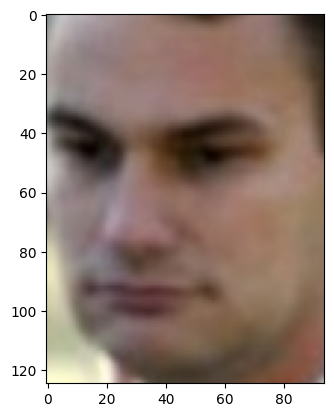

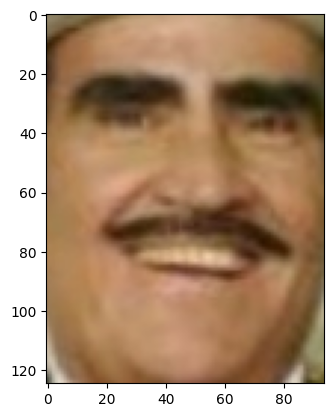

In [50]:
plt.imshow(img1[:, :, ::-1])
plt.show()
plt.imshow(img2[:, :, ::-1])
plt.show()

In [66]:
model = 'VGG-Face'
resp = DeepFace.verify(img1, img2, model_name=model ,enforce_detection=False)

In [67]:
resp

{'verified': False,
 'distance': 0.5219621928646675,
 'threshold': 0.4,
 'model': 'VGG-Face',
 'detector_backend': 'opencv',
 'similarity_metric': 'cosine',
 'facial_areas': {'img1': {'x': 0, 'y': 0, 'w': 94, 'h': 125},
  'img2': {'x': 0, 'y': 0, 'w': 94, 'h': 125}},
 'time': 0.38}

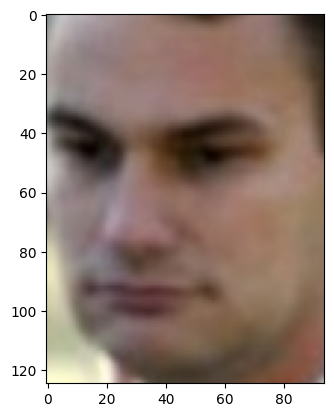

In [69]:
# cropped image by facial areas
dummy = img1[0: 125, 0: 94]
plt.imshow(dummy[:, :, ::-1])

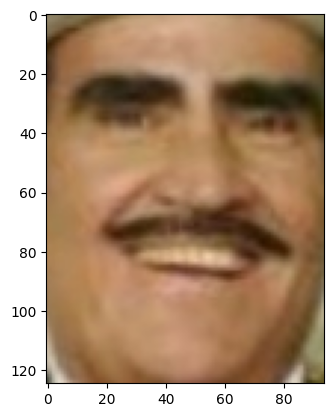

In [68]:
dummy2 = img2[0: 125, 0: 94]
plt.imshow(dummy2[:, :, ::-1])